A collection of scripts to visualise the results for stationary bandits. More details on the algorithms can be found at [Stationary Bandits](stationary_bandits_comparison.ipynb).

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-notebook')
sns.set(color_codes=True)

mpl.rcParams['figure.figsize'] = [15, 5]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 300

%matplotlib inline

Before we compare the active inference algorithm with Thompson sampling and the UCB algorithm, we will illustrate how the values of action precision $\gamma$ and the precision of prior preferences $\lambda$ impact cumulative regret of the active inference agent, as a function of arm number $K$ and difficulty $\epsilon$. Bellow we show the expected regret rate $r(T)$ after $T=10^4$ trials. We define the regret rate as the trial and ensamble average of the cumulative regret. Hence,

$$r(T) = \frac{1}{T} E[R(T)] = \frac{1}{N \cdot T} \sum_{n=1}^N \sum_{t=1}^T \left[p_{max} - p_{a_t^n}\right],$$

where $p_{a_t^n}$ denotes the probability associated with the arm that was selected on the $t$th trial and the $n$th sample. Note that $p_max = \frac{1}{2} + \epsilon$ and that in the case of stationary bandits the optimal arm does not change. Hence, we can fix the optimal arm to choice $a_t^n=1$. Hence we can rewrite the above expression as 

$$ r(T) = \epsilon \left(1 - p(a^*) \right), \qquad p(a^*) = \frac{1}{N \cdot T}\sum_{n=1}^N \sum_{t=1}^T \delta_{a_t^n, 1}.$$

For example, in the case of random choices with unifrom probability over arms we get the following regret rate

$$ r(T) = \epsilon \frac{K-1}{K} $$

we will use this as a regerence line on the following plots. 

In [8]:
tmp = np.load('res_AI_Ks_e35.npz')

In [9]:
for keys in tmp.keys():
    print(keys)

EFE_K5
SUP_K5
APP_K5
EFE_K10
SUP_K10
APP_K10
EFE_K20
SUP_K20
APP_K20
EFE_K40
SUP_K40
APP_K40
EFE_K80
SUP_K80
APP_K80


In [12]:
a = {'a': np.ones(10), 'b': np.ones(10)}

np.stack([a, a])

array([{'a': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'b': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])},
       {'a': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'b': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}],
      dtype=object)

In [125]:
def density_plots(algo_name, regrets, eps, Ks):
    fig, axes = plt.subplots(len(eps), len(Ks), sharey=True, sharex=True, figsize=(15, 10))
    for i, ϵ in enumerate(eps):
        for j, K in enumerate(Ks):
            sns.heatmap(np.flip(regrets[algo_name][ϵ][K].reshape(len(gammas), len(lambdas)), axis=0), 
                        vmin=0., 
                        vmax=.05, 
                        cmap='magma', 
                        ax=axes[i, j], 
                        cbar=False)
            if i == 0:
                axes[i, j].set_title(r'$K={}$'.format(K))
            if i == len(eps) - 1:
                axes[i, j].set_xlabel(r'$\lambda$')
                plt.setp(axes[i, j], 
                         xticks=[0, 4, 8, 12, 16],
                         xticklabels=(10.*lambdas).astype(np.int16)[::4]/10.)

        axes[i, 0].set_yticklabels(np.flip(gammas.astype(np.int16)[::2]));
        axes[i, 0].set_ylabel(r'$\gamma$');
        
        axt = axes[i, -1].twinx()
        axt.set_yticklabels([])
        axt.set_ylabel(r'$\epsilon={}$'.format(ϵ/10), rotation=-90)
        axt.grid(False)
        axt.tick_params(left=False, right=False)
        axes[i, -1].tick_params(left=False)

    return fig

In [3]:
gammas = np.arange(1., 21., 1.)
lambdas = np.arange(.0, 4., .2)
Ks = [3, 10, 20, 40, 80, 100]

In [121]:
from collections import defaultdict

reg_summ = defaultdict(lambda: {})
for ϵ in [10, 25, 40]:
    tmp = np.load('res_AI_Ks_e{}.npz'.format(ϵ))
    for name in ['EFE', 'SUP', 'APP']:
        reg_summ[name][ϵ] = {}
        for K in Ks:
            reg_summ[name][ϵ][K] = tmp[name + '_K{}'.format(K)].mean(-1)[0, ..., -1]

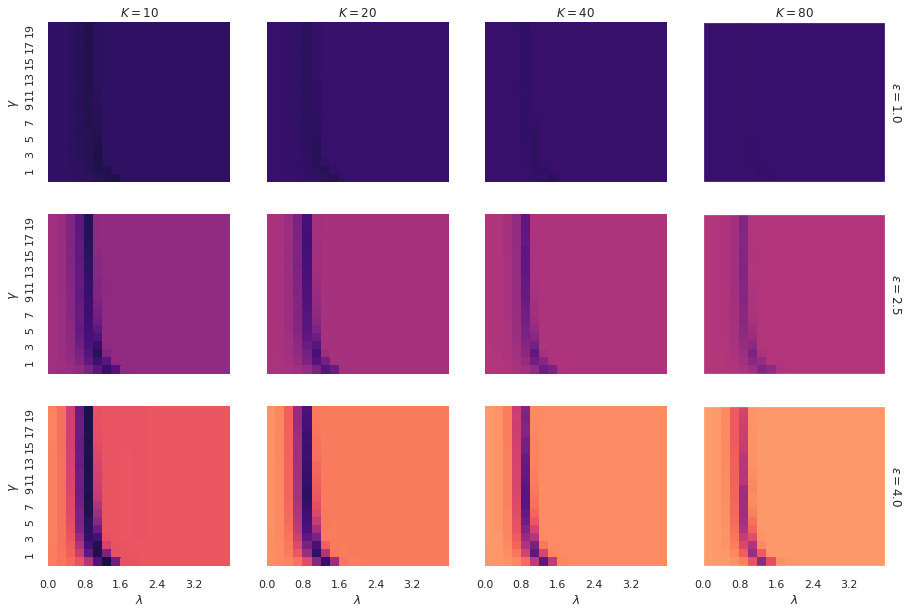

In [126]:
fig = density_plots('EFE', reg_summ, [10, 25, 40], [10, 20, 40, 80])

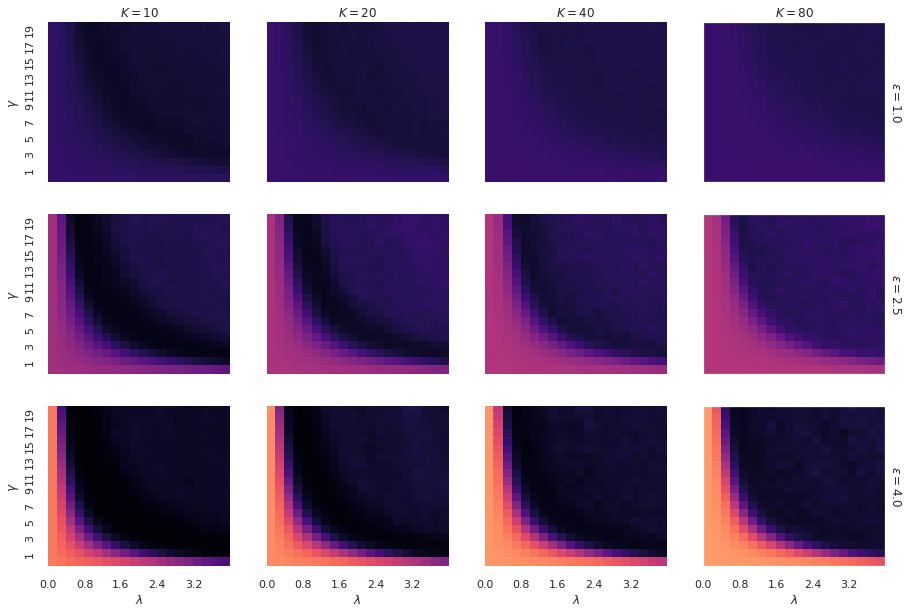

In [127]:
fig = density_plots('SUP', reg_summ, [10, 25, 40], [10, 20, 40, 80])

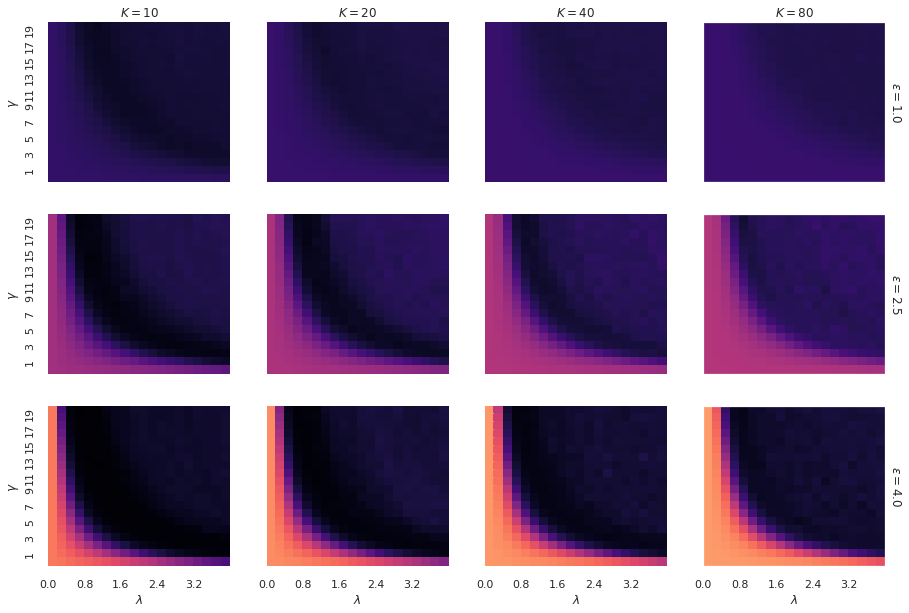

In [128]:
fig = density_plots('APP', reg_summ, [10, 25, 40], [10, 20, 40, 80])

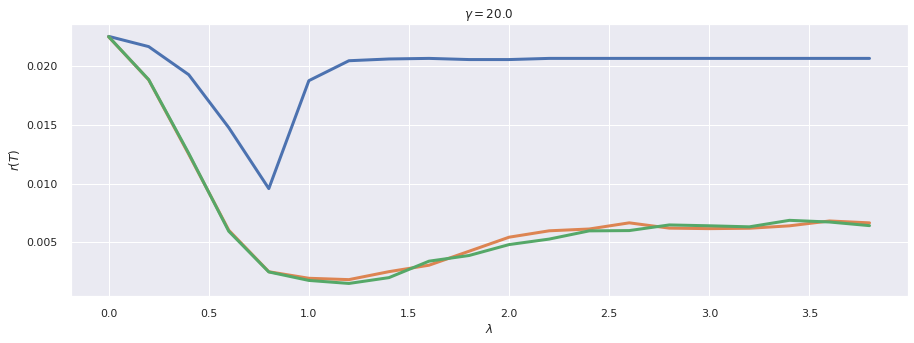

In [73]:
plt.figure(figsize=(15, 5))
eps = 25
K = 10
g = 19
plt.plot(lambdas, reg_summ['EFE'][eps][K].reshape(len(gammas), len(lambdas))[10], lw=3, label='EFE');
plt.plot(lambdas, reg_summ['SUP'][eps][K].reshape(len(gammas), len(lambdas))[10], lw=3, label='SUP');
plt.plot(lambdas, reg_summ['APP'][eps][K].reshape(len(gammas), len(lambdas))[10], lw=3, label='APP');
plt.xlabel(r'$\lambda$');
plt.ylabel(r'$r(T)$');
plt.title(r'$\gamma={}$'.format(gammas[g]));

In what follows we will compare the active inference based agent ($\textrm{AI}_{\textrm{APP}}$) with agents using the upper confidence bound (UCB) and the optimistic Thomspon sampling (OTS) as action selection algorithms. We will first consider the depndence of regret rate on the number of arms $K$ and difficulty $\epsilon$, after $T=10^4$ steps, and than look in more details at the step vise dependence of the regret rate $r(t)$.

In [141]:
Ks = [5, 10, 20, 40, 80]
for ϵ in [10, 25, 40]:
    tmp = np.load('res_RL_Ks_e{}.npz'.format(ϵ))
    for name in ['OTS', 'UCB', 'BUCB']:
        reg_summ[name][ϵ] = {}
        for K in Ks:
            reg_summ[name][ϵ][K] = tmp[name + '_K{}'.format(K)][0]

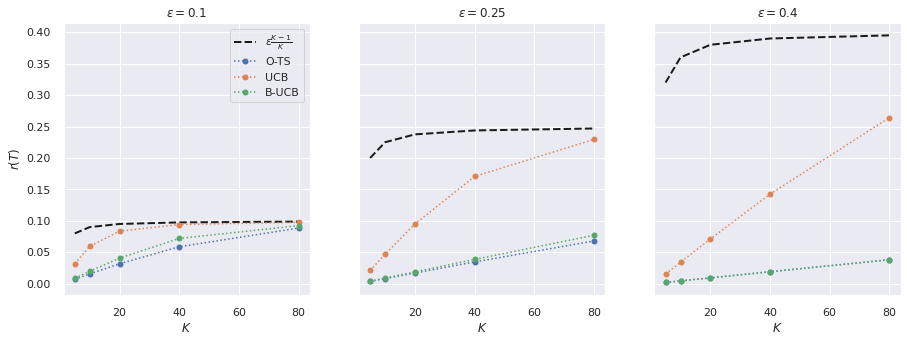

In [172]:
Ks = np.array(Ks)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
T=10000

for i, eps in enumerate([10, 25, 40]):
    axes[i].plot(Ks, .01*eps * (Ks - 1)/Ks, 'k--', lw=2, label=r'$\epsilon\frac{K-1}{K}$');
#     axes[i].plot(Ks, np.sqrt(Ks * T * np.log(T))/T, 'r--', lw=2, label=r'$\frac{\sqrt{K T \ln T}}{T}$');
    
    axes[i].set_title(r'$\epsilon={}$'.format(eps/100.))
    axes[i].set_xlabel('$K$')

    ots = []
    ucb = []
    bucb = []
    for K in Ks:
        ots.append(reg_summ['OTS'][eps][K].mean(-1)[-1])
        ucb.append(reg_summ['UCB'][eps][K].mean(-1)[-1])
        bucb.append(reg_summ['BUCB'][eps][K].mean(-1)[-1])
        
    axes[i].plot(Ks, ots, 'o:', label='O-TS')
    axes[i].plot(Ks, ucb, 'o:', label='UCB')
    axes[i].plot(Ks, bucb, 'o:', label='B-UCB')
#     plt.xlabel(r'$K$')
#     plt.ylabel(r'$ \left\langle R(T) \right\rangle /T$')
#     plt.legend()
axes[0].set_ylabel(r'$r(T)$')
axes[0].legend()
fig.savefig('comparisson.png', dpi=300)

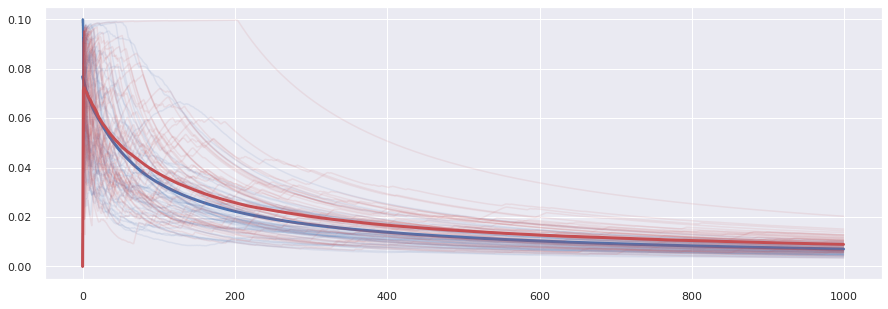

In [149]:
plt.figure(figsize=(15,5))
plt.plot(reg_summ['OTS'][10][5][:, ::10], 'b', alpha=.1);
plt.plot(reg_summ['OTS'][10][5].mean(-1), 'b', lw=3)

plt.plot(reg_summ['BUCB'][10][5][:, ::10], 'r', alpha=.1);
plt.plot(reg_summ['BUCB'][10][5].mean(-1), 'r', lw=3)


In [96]:
Ks = [3, 10, 100]
mean_reg = defaultdict(lambda: [])
for K in Ks:
    sequence = simulator(process, learning, optimistic_selection, N=N, T=T, K=K, eps=eps)
    choices1 = sequence['choices']
    tmp_mr = np.cumsum((1 - (choices1 == 0).astype(np.float32)) * eps, 0).mean(-1)[times-1]/times.astype(np.float32)
    mean_reg['OT_K{}'.format(K)] = tmp_mr
    
    sequence = simulator(process, learning, ucb_selection, N=N, T=T, K=K, eps=eps)
    choices2 = sequence['choices']
    tmp_mr = np.cumsum((1 - (choices2 == 0).astype(np.float32)) * eps, 0).mean(-1)[times-1]/times.astype(np.float32)
    mean_reg['UCB_K{}'.format(K)] = tmp_mr

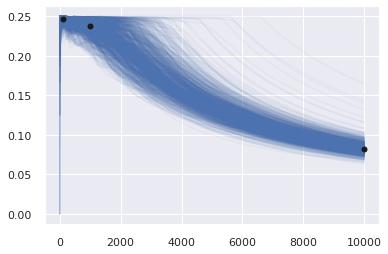

In [105]:
plt.plot(np.cumsum((1 - (choices1 == 0).astype(np.float32)) * eps, 0)/np.arange(1, T+1)[:, None], 'b', alpha=.05);
plt.plot(times, mean_reg['OT_K100'], 'ok')

In [107]:
mean_reg_efe = np.load('res_EFE_Ks_e25.npz')
for K in [3, 10, 100]:
    name = 'EFE_K{}'.format(K)
    mean_reg[name] = mean_reg_efe[name].reshape(len(gammas), len(lambdas), -1)[-1, 4]

In [11]:
lam = .8
gamma = 15.
selection = lambda *args: efe_selection(*args, gamma=gamma, lam=lam)
sequence4 = simulator(process, learning, selection, N=N, T=T, K=K, eps=eps)

lam = .8
gamma = 15.
selection = lambda *args: sup_selection(*args, gamma=gamma, lam=lam)
sequence5 = simulator(process, learning, selection, N=N, T=T, K=K, eps=eps)

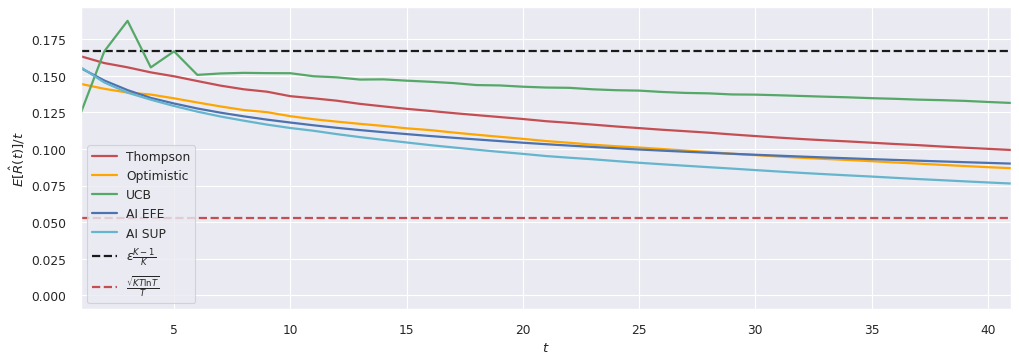

In [12]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([1, 40+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

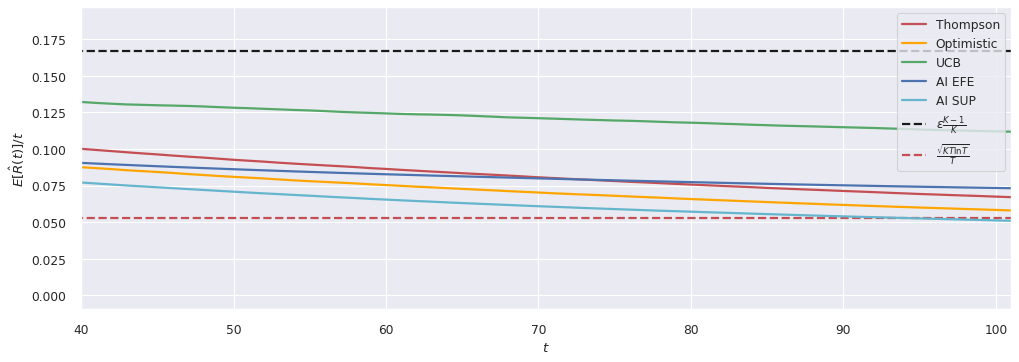

In [15]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([40, 100+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

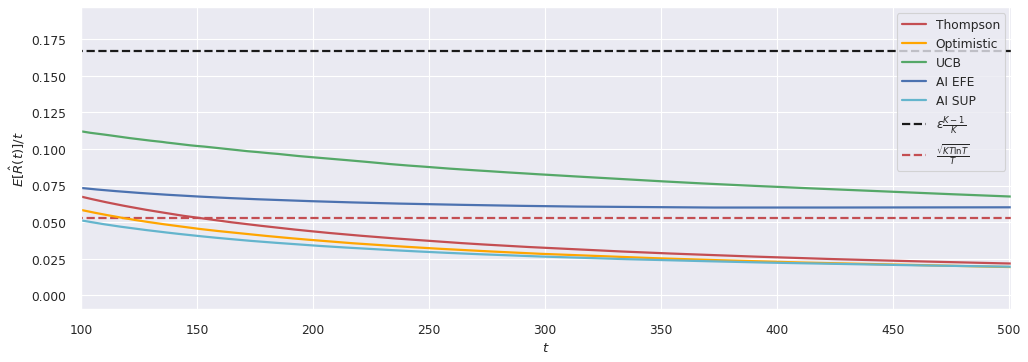

In [16]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([100, 500+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

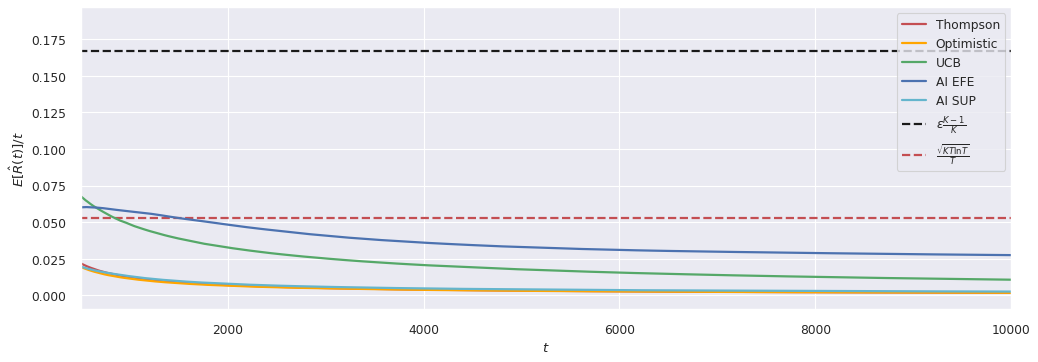

In [17]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([500, 10000+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

### TODO:

* establish functional or numerical relationship between $\gamma^*$, $\lambda^*$ and $K$, $\epsilon$.
* for AI SUP algorithm figure out $\gamma^* = f(\lambda, K, \epsilon)$? 
* introduce learning of $\gamma$ and $\lambda$. Would the learning find values of $\lambda$, $\gamma$ that minimize regret?